In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = "data/raw/processed_images"

# Dimensions standardisées
img_height, img_width = 128, 128
batch_size = 32

# Générateurs d'images avec normalisation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=f"{dataset_path}/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    directory=f"{dataset_path}/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 491 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# load mobilenetV2 without last layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # freezing the base model

# adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Dropout pour éviter l'overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binaire : cataracte ou pas

# create & compile final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# display model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

2025/04/23 12:42:40 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/04/23 12:42:40 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
c:\Users\hiron\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 856ms/step - accuracy: 0.7708 - loss: 0.4504 - val_accuracy: 0.9587 - val_loss: 0.1039
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 693ms/step - accuracy: 0.9422 - loss: 0.1291 - val_accuracy: 0.9752 - val_loss: 0.0843
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 712ms/step - accuracy: 0.9723 - loss: 0.0903 - val_accuracy: 0.9669 - val_loss: 0.0702
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 680ms/step - accuracy: 0.9660 - loss: 0.0984 - val_accuracy: 0.9752 - val_loss: 0.0668
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 682ms/step - accuracy: 0.9710 - loss: 0.0585 - val_accuracy: 0.9669 - val_loss: 0.0630
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 685ms/step - accuracy: 0.9853 - loss: 0.0482 - val_accuracy: 0.9752 - val_loss: 0.0675
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 679ms/step - accuracy: 0.9843 - loss: 0.0374 - val_accuracy: 0.9752 - val_loss: 0.0638
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 671ms/step - accuracy: 0.9864 - loss: 0.0499 - val_accu

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.9795 - loss: 0.0677
Test Accuracy: 0.97


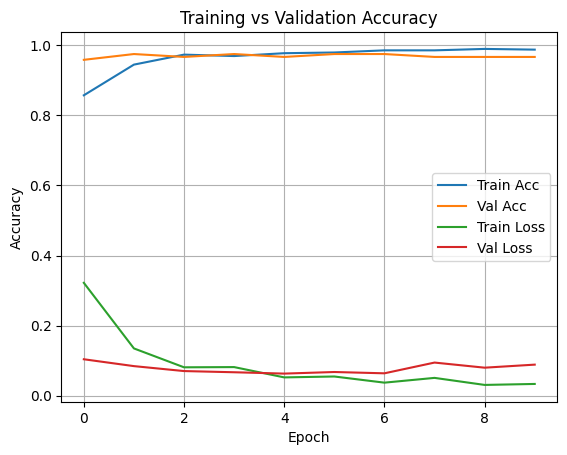

In [3]:
import mlflow.keras, time
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

# set mlflow experiment
mlflow.set_experiment("cataract_classification")

# create a tensorboard callback
log_dir = f"logs/cnn_mobilnet_{int(time.time())}"
tensorboard_callback = TensorBoard(log_dir=log_dir)

with mlflow.start_run(run_name="MobilnetV2_Model"):
    mlflow.keras.autolog()

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=[tensorboard_callback]
    )

    model.save("cataract_mobilnetv2_classifier.h5")

loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.show()

2025/04/23 12:47:01 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/04/23 12:47:01 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 851ms/step - accuracy: 0.8551 - loss: 0.5189 - val_accuracy: 0.8595 - val_loss: 0.7679
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 677ms/step - accuracy: 0.9630 - loss: 0.0964 - val_accuracy: 0.9504 - val_loss: 0.5746
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 691ms/step - accuracy: 0.9889 - loss: 0.0270 - val_accuracy: 0.9587 - val_loss: 0.5493
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 695ms/step - accuracy: 0.9998 - loss: 0.0081 - val_accuracy: 0.9421 - val_loss: 0.7506
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 733ms/step - accuracy: 0.9984 - loss: 0.0055 - val_accuracy: 0.9339 - val_loss: 0.7458
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 720ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9339 - val_loss: 0.8057
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 690ms/step - accuracy: 0.9992 - loss: 0.0047 - val_accuracy: 0.9339 - val_loss: 0.8447
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.9983 - loss: 0.0032 - val_accu

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.9381 - loss: 0.6631
Test Accuracy: 0.93


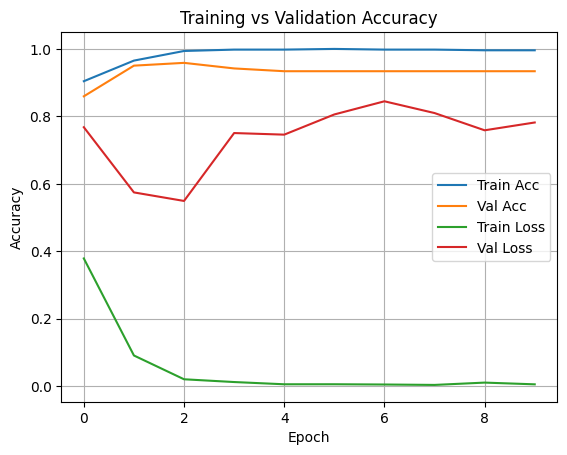

In [4]:
# unlock the base model for fine-tuning
base_model.trainable = True

# fine-tune the last 30 layers of the base model
for layer in base_model.layers[:-30]:
    layer.trainable = False

# compile the model again
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

with mlflow.start_run(run_name="MobilnetV2_Model"):
    mlflow.keras.autolog()

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=[tensorboard_callback]
    )

    model.save("cataract_mobilnetv2_finetuned_classifier.h5")

loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.show()
